# FFM - ANN for Weather Forecast using DWD weather- and precipitation-data

## Import data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np


df_weather = pd.read_csv('Daten/ffm/ffm_weather.txt', sep=";", parse_dates=["MESS_DATUM"])
df_weather = df_weather.drop(["STATIONS_ID", "  QN", "eor"], axis=1)
df_weather.set_index("MESS_DATUM", inplace=True, drop=True)

dtype = {"RWS_10": np.float64}
df_rain = pd.read_csv('Daten/ffm/ffm_rain.txt', sep=";", parse_dates=["MESS_DATUM"], dtype=dtype)
df_rain = df_rain.drop(["STATIONS_ID","  QN", "RWS_DAU_10", "RWS_IND_10", "eor"], axis=1)
df_rain.set_index("MESS_DATUM", inplace=True, drop=True)

dtype = {"V_N": np.int16}
df_cloudy = pd.read_csv('Daten/ffm/ffm_cloudy.txt', sep=",", parse_dates=["MESS_DATUM"])
df_cloudy.set_index("MESS_DATUM", inplace=True, drop=True)
df_cloudy = df_cloudy.resample(rule='10T', axis=0).pad()
df_cloudy = df_cloudy["2010":"2019"]

df = pd.concat([df_weather, df_cloudy, df_rain], axis=1)
df


,PP_10,TT_10,TM5_10,RF_10,TD_10,V_N,RWS_10
MESS_DATUM,,,,,,,
2010-01-01 00:00:00,978.1,3.8,3.5,95.2,3.1,8,0.0
2010-01-01 00:10:00,978.2,3.7,3.5,95.2,3.0,8,0.0
2010-01-01 00:20:00,978.3,3.7,3.4,95.1,3.0,8,0.0
2010-01-01 00:30:00,978.3,3.5,3.3,94.7,2.7,8,0.0
2010-01-01 00:40:00,978.3,3.4,3.2,94.7,2.6,8,0.0
...,...,...,...,...,...,...,...
2019-12-31 23:10:00,1023.4,0.2,-1.1,88.2,-1.5,6,0.0
2019-12-31 23:20:00,1023.3,0.5,-0.7,88.5,-1.2,6,0.0
2019-12-31 23:30:00,1023.3,0.2,-1.4,89.2,-1.4,6,0.0


## Raw Data Visualization

/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/one/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


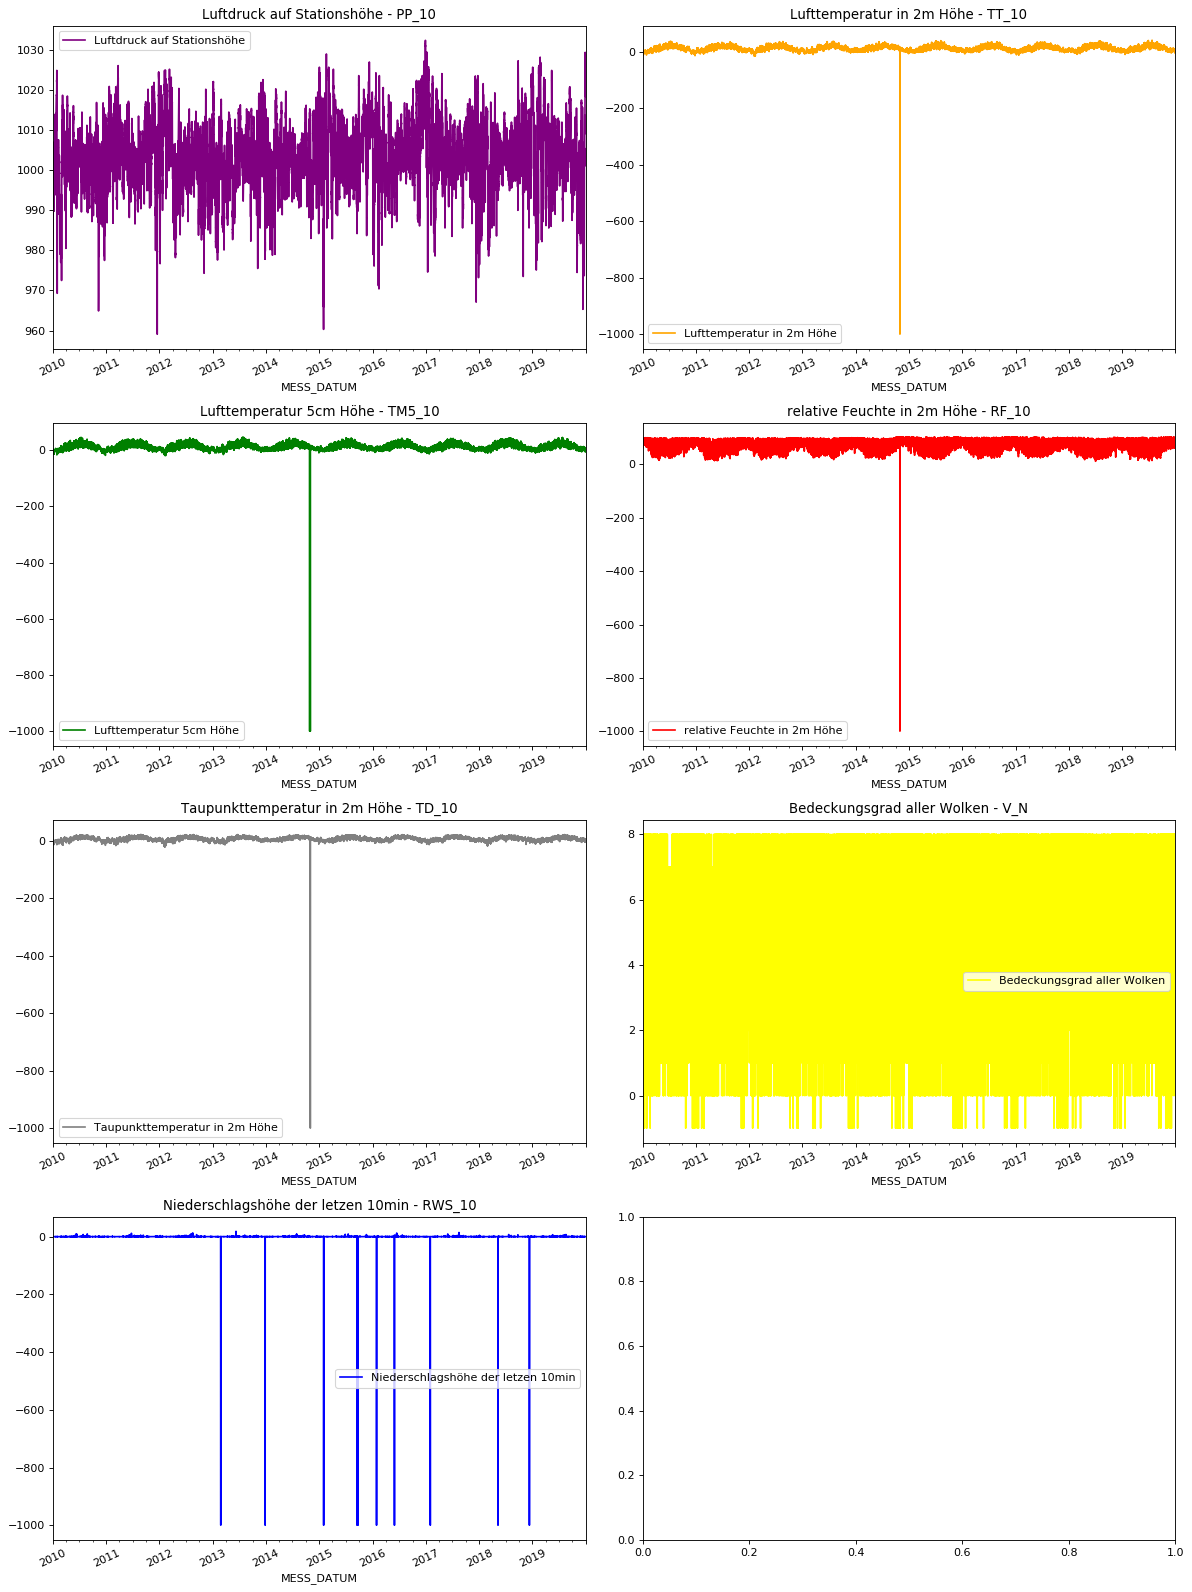

In [3]:
titles = [
    "Luftdruck auf Stationshöhe",
    "Lufttemperatur in 2m Höhe",
    "Lufttemperatur 5cm Höhe",
    "relative Feuchte in 2m Höhe",
    "Taupunkttemperatur in 2m Höhe",
    "Bedeckungsgrad aller Wolken",
    "Niederschlagshöhe der letzen 10min",
]

feature_keys = [
    "PP_10",
    "TT_10",
    "TM5_10",
    "RF_10",
    "TD_10",
    "V_N",
    "RWS_10",
]

colors = [
    "purple",
    "orange",
    "green",
    "red",
    "gray",
    "yellow",
    "blue",
]

def plot_data(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


plot_data(df)

## Clean data

In [4]:
feature_keys = [
    "PP_10",
    "TT_10",
    "TM5_10",
    "RF_10",
    "TD_10",
    "V_N",
    "RWS_10",
]

for key in feature_keys:
    df.loc[df[key]==-999.0, [key]] = 0

df.loc[df["V_N"]==-1.0, ["V_N"]] = 0

# Visualize (more) clean data

/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/one/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


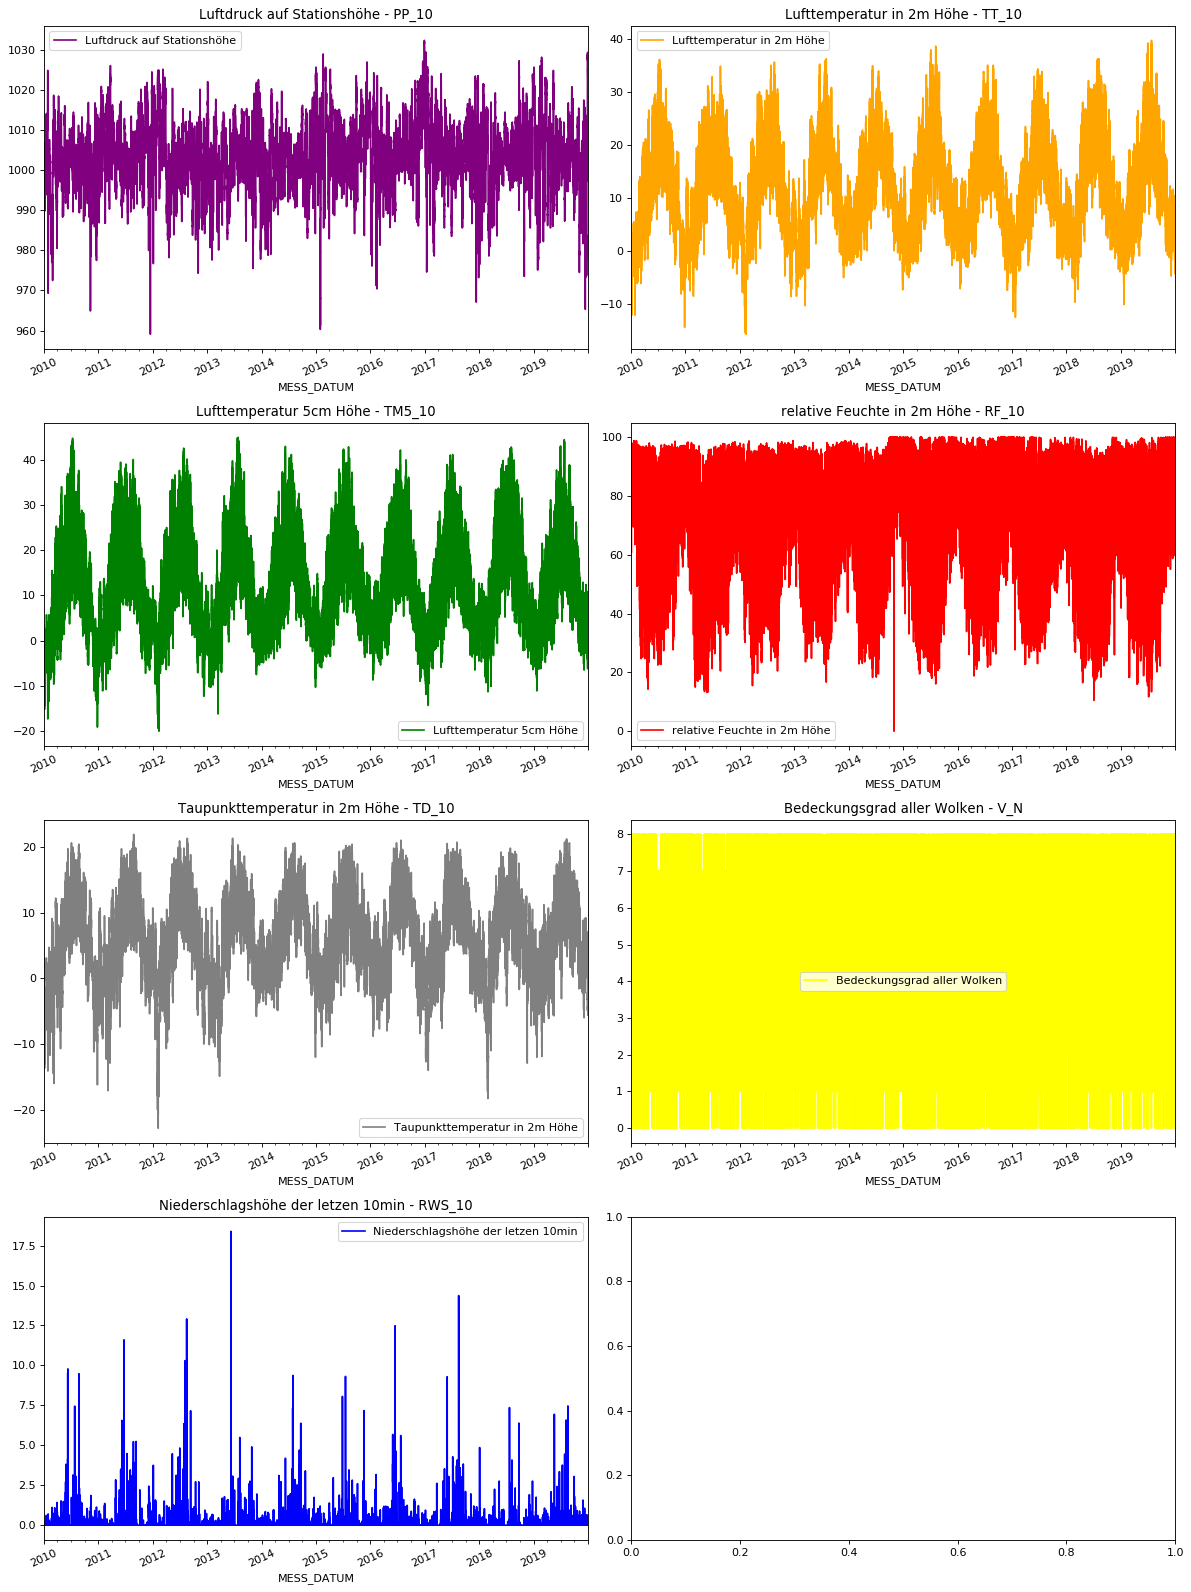

In [5]:
plot_data(df)

## Create Feature Correlation Heatmap


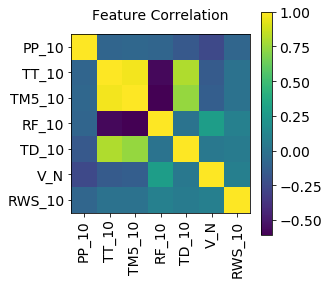

In [6]:
def plot_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation", fontsize=14)
    plt.show()


plot_heatmap(df)


<p>PP_10: "Luftdruck auf Stationshöhe"</p>
<p>TT_10: "Lufttemperatur in 2m Höhe"</p>
<p>TM5_10: "Lufttemperatur 5cm Höhe"</p>
<p>RF_10: "relative Feuchte in 2m Höhe"</p>
<p>TD_10: "Taupunkttemperatur in 2m Höhe"</p>
<p>V_N: "Bedeckungsgrad aller Wolken"</p>

<p>RWS_10: "Niederschlagshöhe der letzen 10min"</p>

<p>--> Lufttemperatur in 2m Höhe und 5 cm Höhe korreliert stark</p>
<p>--> Redundanz </p>
<p>--> Lufttempartur in 5dm Höhe wir rausgeschmießen</p>

## Preprocessing

In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 1 # time interval = 10 min

past = 720
future = 6
learning_rate = 0.001
batch_size = 256
epochs = 20


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

"""
0, 1, 3, 4, 5 sind die indizes in der features --> 2 ausgelassen weil 
TMP5_10 wird weggelassen (Redundanz)
"""

print(
    "The selected parameters are:", 
    ", ".join([titles[i] for i in [0, 1, 3, 4, 5, 6]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 3, 4, 5, 6]]
features = df[selected_features]
features.index = df.index
features.head()

data_mean = features.values[:train_split].mean(axis=0)
data_std = features.values[:train_split].std(axis=0)
print("\n"+"data_mean: "+ str(data_mean)+". data_std: "+ str(data_std))

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()
features = features.fillna(0)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]#

"""
# training data

"""

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(6)]].values # only 6 indices because we kicked one
y_train = features.iloc[start:end][[5]] # 5: precipitation


sequence_length = int(past / step)


dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

"""
## validation data
"""

x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(6)]].values # only 6 indices because we kicked one
y_val = features.iloc[label_start:][[5]]# 5: precipitation



dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


The selected parameters are: Luftdruck auf Stationshöhe, Lufttemperatur in 2m Höhe, relative Feuchte in 2m Höhe, Taupunkttemperatur in 2m Höhe, Bedeckungsgrad aller Wolken, Niederschlagshöhe der letzen 10min

data_mean: [1.00360690e+03 1.09140935e+01 7.42748043e+01 5.87742075e+00
 5.40090796e+00 1.11788814e-02]. data_std: [ 8.56925618  8.06991744 18.53155785  6.4427604   2.60384797  0.11711443]
Input shape: (256, 720, 6)
Target shape: (256, 1)


'\nprint("______________")\nprint(x_val)\nprint(x_val.shape)\nprint(type(x_val))'

## Training

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 720, 6)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
1466/1466 [==============================] - 1290s 878ms/step - loss: 0.9712 - val_loss: 0.7907

Epoch 00001: val_loss improved from inf to 0.79069, saving model to model_checkpoint_ffm_new1.h5


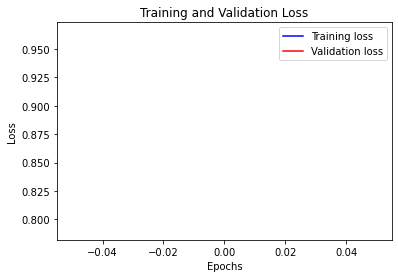

In [9]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint_ffm_new1.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



## Load saved ANN-Model

In [8]:
def load_model(weights_path, dataset):
    for batch in dataset.take(1):
        inputs, targets = batch

    inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
    model.summary()

    model.load_weights(weights_path)
    
    return model
    
model1 = load_model(weights_path="saved/15ep_model_checkpoint_ffm.h5",
                   dataset=dataset_val)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 720, 6)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


## Make predictions with weather input

In [23]:
def unnormalize(n_data, mean, std):
    return (n_data * std) + mean


def make_prediction(model, df, delta, data_mean, data_std):
    """this function makes predictions with the trained ANN
    :model: trained ANN model
    :df: Dataframe with weather data
    :delta: time-delta to the prediction (how far in the future)
    """
    prediction_list = []
    for i in reversed(range(delta)):
        if i !=0:
            upper_lim = -720-i
            bottom_lim = -i
        else:
            upper_lim = -720
            bottom_lim = None

        df_timespan = df.iloc[upper_lim:bottom_lim]


        x = tf.convert_to_tensor(df_timespan.tail(720).values, dtype=tf.float32)
        x= tf.reshape(x, (1, 720, 6), name=None)
        un_value = unnormalize(model1.predict(x)[0,0], data_mean, data_std)
        if un_value < 0.1:
            un_value = 0
        prediction_list.append(un_value)
        
    return prediction_list

def give_results(prediction_list):
    """this function returns the extreme weather indicator for the predicted timeframe 
    """
    sum_prec = sum(prediction_list)
    
    if sum_prec<1:
        return 0
    elif sum_prec >= 1 and sum_prec < 10:
        return 1
    else:
        return 2

df_rel = df.copy()
df_rel.drop(["TM5_10"], axis=1, inplace=True)

pred_list = make_prediction(model1, df_rel, 6, data_mean[-1], data_std[-1])
give_results(pred_list)


0

## Visualize Predictions

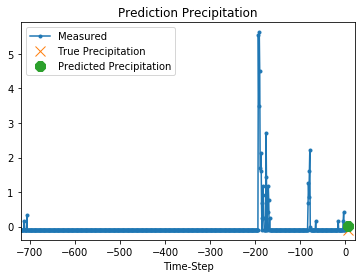

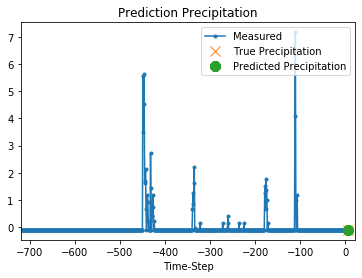

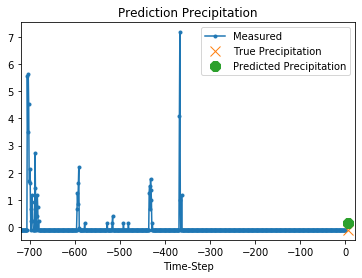

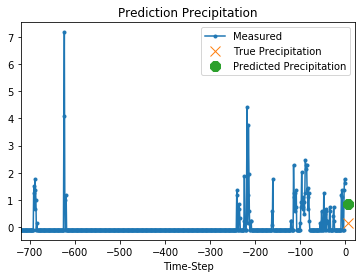

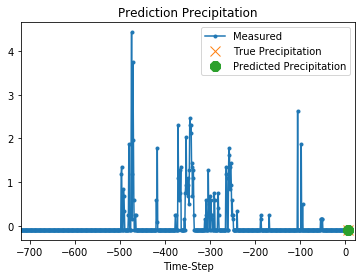

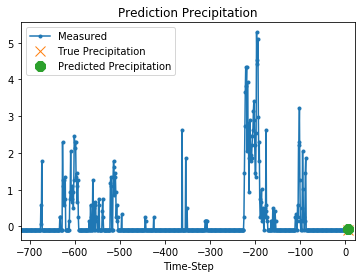

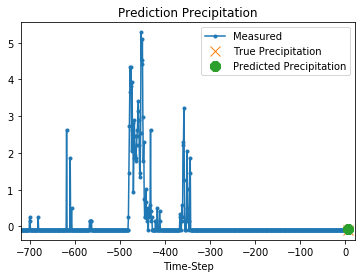

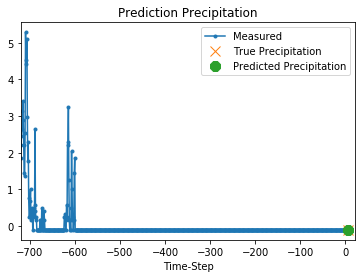

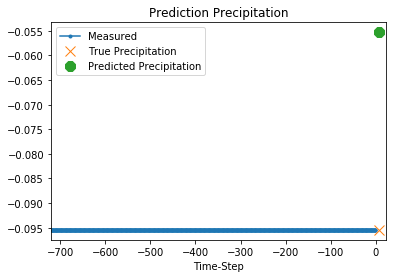

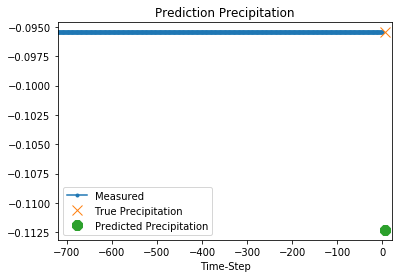

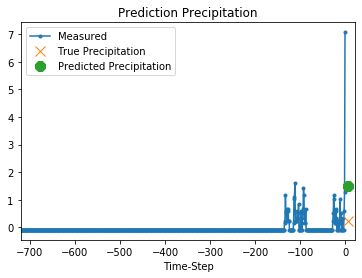

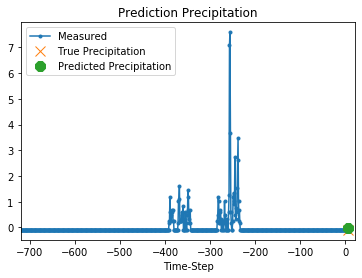

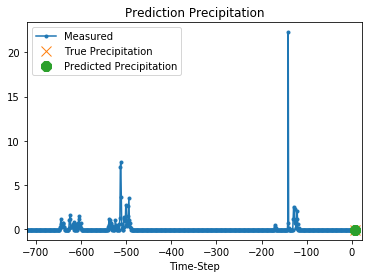

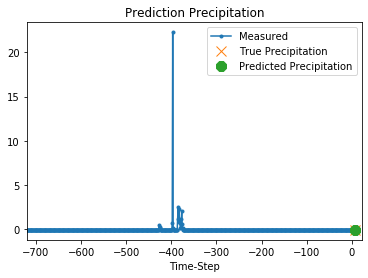

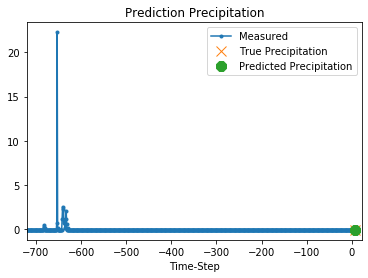

In [12]:
def show_plot(plot_data, delta, title):
    labels = ["Measured", "True Precipitation", "Predicted Precipitation"]
    marker = [".-", "x", "8"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(15):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model1.predict(x)[0]], 
        6,
        "Prediction Precipitation",
    )